# ⚡Forecasting Hourly Electricity Production Using LSTM and TCN🔌💡


# Aims and Objectives of this notebook


* The main aim of this notebook is to forecast electricity production using two different deep learning models such as LSTM (Long Short-Term Memory) and TCN (Temporal Convolutional Networks).
* The first part will focus on analyzing and exploring the data.
* The second part will be dedicated to forecasting, where we will build and evaluate both the LSTM and TCN models. 
* Lastly, we will compare the performance of both models and provide recommendations based on their predictive power and efficiency in the context of electricity production forecasting.


# Dataset

## Dataset Link


**Dataset link:** https://www.kaggle.com/datasets/stefancomanita/hourly-electricity-consumption-and-production/data

## About Dataset


* This is a hourly Electricity Consumption and Production by Type in Romania for 5.5 years
* It includes the hourly consumption and production, and the production is split in one of the categories: Nuclear, Wind, Hydroelectric, Oil and Gas, Coal, Solar, Biomass.
* All values of this dataset are in MWs.

## About Dataset Columns


| **Column**            | **Description**                                                                 |
|-----------------------|---------------------------------------------------------------------------------|
| **Timestamp**         | The date and hour of the recording (e.g., YYYY-MM-DD HH:00).                    |
| **Consumption (MW)**  | The total electricity consumption in megawatts (MW) during that hour.           |
| **Total Production (MW)** | The total electricity production in megawatts (MW) during that hour.       |
| **Nuclear (MW)**      | Electricity produced from nuclear power plants.                                 |
| **Wind (MW)**         | Electricity produced from wind turbines.                                        |
| **Hydroelectric (MW)** | Electricity produced from hydroelectric power plants.                          |
| **Oil and Gas (MW)**  | Electricity produced from oil and gas power plants.                             |
| **Coal (MW)**         | Electricity produced from coal power plants.                                    |
| **Solar (MW)**        | Electricity produced from solar panels.                                         |
| **Biomass (MW)**      | Electricity produced from biomass energy sources.                               |


In [2]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install wandb

Note: you may need to restart the kernel to use updated packages.


# Import Libraries


In [7]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot, autocorrelation_plot

# Scikit-learn modules for preprocessing, model selection, and evaluation
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# TensorFlow and Keras for deep learning
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Bidirectional, Dense, TimeDistributed, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.optimizers import Adam

# Weights & Biases for experiment tracking
import wandb
from wandb.integration.keras import WandbMetricsLogger

# Time module for time-related functions
import time

In [8]:
print("TensorFlow version:", tf.__version__)
print("GPU disponibles:", tf.config.list_physical_devices('GPU'))
print("CUDA dispo:", tf.test.is_built_with_cuda())

TensorFlow version: 2.18.0
GPU disponibles: []
CUDA dispo: False


In [9]:
# Check if GPU is available
physical_devices = tf.config.list_physical_devices('GPU')
print(tf.config.list_physical_devices())
if len(physical_devices) > 0:
    tf.config.set_visible_devices(physical_devices[0], 'GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("Using GPU",physical_devices[0])
else:
    print("GPU not available, using CPU.")

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
GPU not available, using CPU.


# 1st Part Data Analysis


In [10]:
# Path of the dataset
PATH = 'C:\\Users\\ledou\\Documents\\Scolaire\\Hust\Deep Learning\\projet\\DL-HUST\\electricityConsumptionAndProductioction.csv'

df = pd.read_csv(PATH)
df.head()

<>:2: SyntaxWarning: invalid escape sequence '\D'
<>:2: SyntaxWarning: invalid escape sequence '\D'
C:\Users\ledou\AppData\Local\Temp\ipykernel_24804\4046045765.py:2: SyntaxWarning: invalid escape sequence '\D'
  PATH = 'C:\\Users\\ledou\\Documents\\Scolaire\\Hust\Deep Learning\\projet\\DL-HUST\\electricityConsumptionAndProductioction.csv'


,DateTime,Consumption,Production,Nuclear,Wind,Hydroelectric,Oil and Gas,Coal,Solar,Biomass
0,2019-01-01 00:00:00,6352,6527,1395,79,1383,1896,1744,0,30
1,2019-01-01 01:00:00,6116,5701,1393,96,1112,1429,1641,0,30
2,2019-01-01 02:00:00,5873,5676,1393,142,1030,1465,1616,0,30
3,2019-01-01 03:00:00,5682,5603,1397,191,972,1455,1558,0,30
4,2019-01-01 04:00:00,5557,5454,1393,159,960,1454,1458,0,30


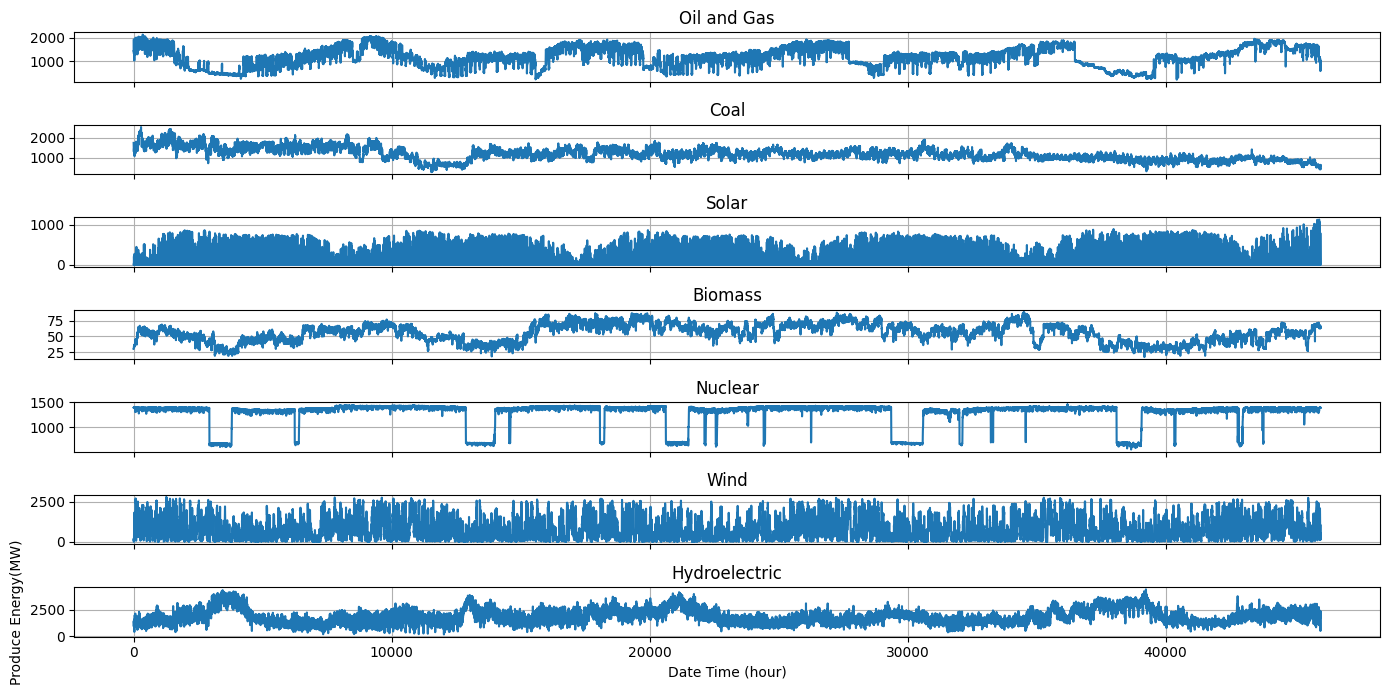

In [11]:
# Extraction of the different sources of energy
energy_sources = ['Oil and Gas', 'Coal', 'Solar', 'Biomass', 'Nuclear', 'Wind', 'Hydroelectric']

# Plotting all energies
fig, axes = plt.subplots(nrows=len(energy_sources), ncols=1, figsize=(14, 7), sharex=True)

for i, source in enumerate(energy_sources):
    axes[i].plot(df.index, df[source], label=source)
    axes[i].set_title(f'{source}')
    axes[i].grid(True)

plt.xlabel('Date Time (hour)')
plt.ylabel('Produce Energy(MW)')
plt.tight_layout()
plt.show()


## Histogram of electricity generation


This code generates overlapping histograms to compare the distribution of electricity generation from various energy sources (such as Nuclear, Wind, Hydroelectric, etc.) using data from the DataFrame df. Each energy source is displayed with a different color, with labeled axes, a legend, and a grid for better readability.

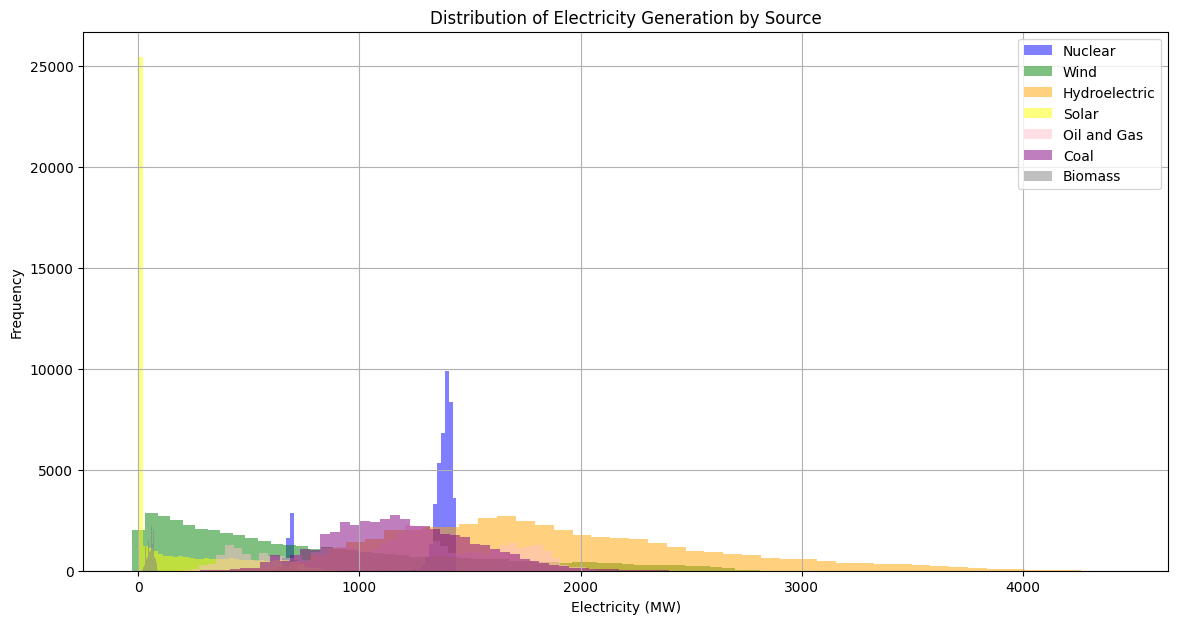

In [12]:
plt.figure(figsize=(14, 7))

plt.hist(df['Nuclear'], bins=50, alpha=0.5, label='Nuclear', color='blue')
plt.hist(df['Wind'], bins=50, alpha=0.5, label='Wind', color='green')
plt.hist(df['Hydroelectric'], bins=50, alpha=0.5, label='Hydroelectric', color='orange')
plt.hist(df['Solar'], bins=50, alpha=0.5, label='Solar', color='yellow')
plt.hist(df['Oil and Gas'], bins=50, alpha=0.5, label='Oil and Gas', color='pink')
plt.hist(df['Coal'], bins=50, alpha=0.5, label='Coal', color='purple')
plt.hist(df['Biomass'], bins=50, alpha=0.5, label='Biomass', color='grey')

plt.xlabel('Electricity (MW)')
plt.ylabel('Frequency')
plt.title('Distribution of Electricity Generation by Source')
plt.legend()
plt.grid(True)
plt.show()


## Consumption and production

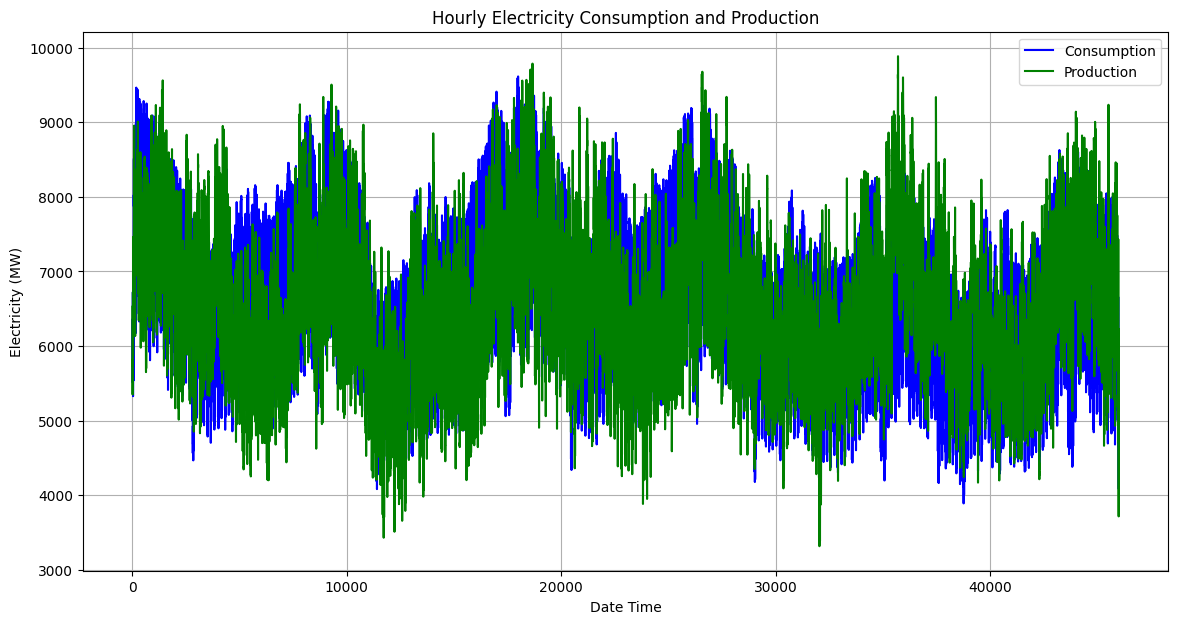

In [13]:
# Display of hourly electricity consumption and production

plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Consumption'], label='Consumption', color='blue')
plt.plot(df.index, df['Production'], label='Production', color='green')
plt.xlabel('Date Time')
plt.ylabel('Electricity (MW)')
plt.title('Hourly Electricity Consumption and Production')
plt.legend()
plt.grid(True)
plt.show()

## Stacked plot mix of energy

This code creates a stacked area plot to visualize the hourly electricity production from different energy sources over time, using data from the DataFrame df. Each source is stacked on top of the others, with labeled axes, a legend on the top left, and a grid for improved readability.

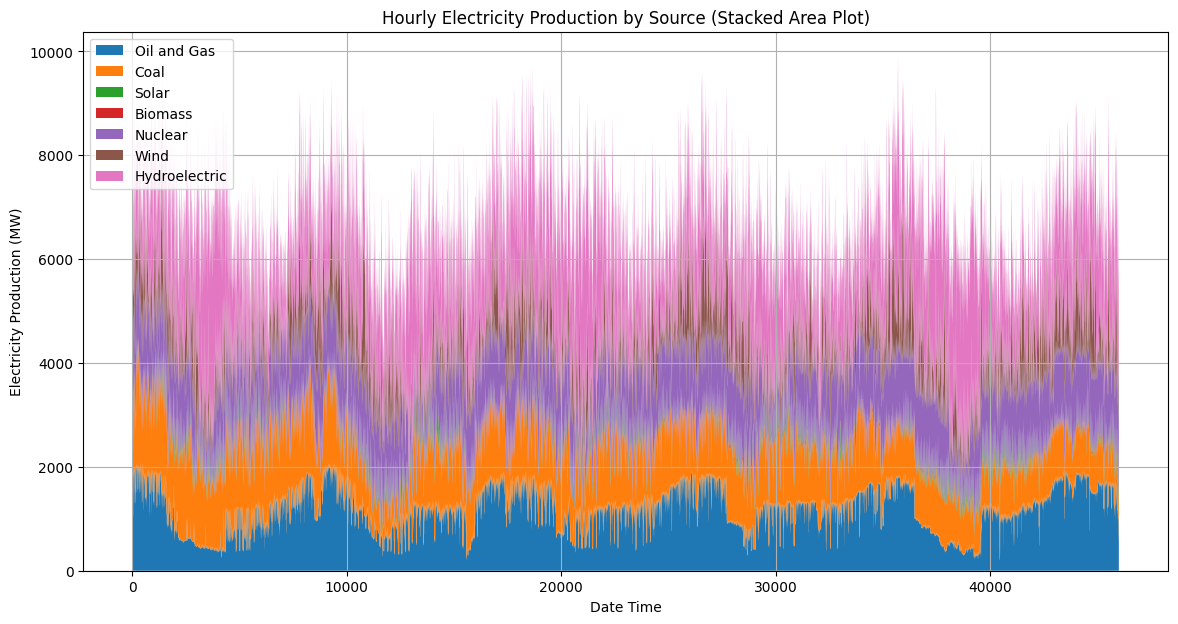

In [14]:
plt.figure(figsize=(14, 7))

plt.stackplot(df.index, [df[source] for source in energy_sources], labels=energy_sources)

plt.xlabel('Date Time')
plt.ylabel('Electricity Production (MW)')
plt.title('Hourly Electricity Production by Source (Stacked Area Plot)')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()


## Lagplot
A Lag Plot is a statistical tool used to analyze the relationships between successive values of a time series. It helps identify the correlation between an observation and its lagged version (e.g., between time 𝑡 and 𝑡+1). If the time series has high autocorrelation, the points in the plot will align along a diagonal line. If the series is random, the points will be more uniformly scattered.

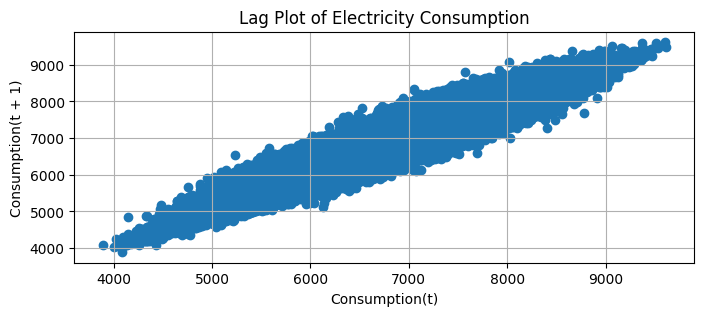

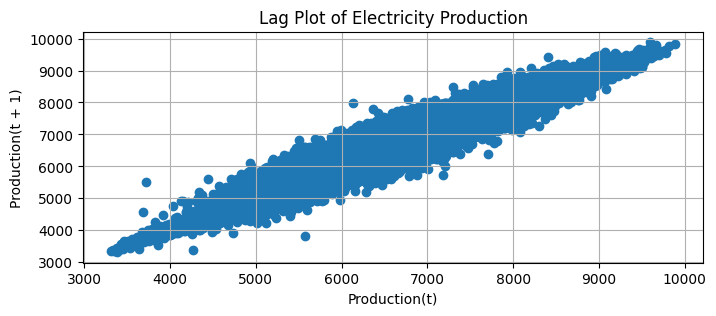

In [15]:
# Convert the 'DateTime' column to datetime
df['DateTime'] = pd.to_datetime(df['DateTime'])

# Lagplot for consumption
plt.figure(figsize=(8, 3))
lag_plot(df['Consumption'])
plt.title('Lag Plot of Electricity Consumption')
plt.xlabel('Consumption(t)')
plt.ylabel('Consumption(t + 1)')
plt.grid(True)
plt.show()

# Lagplot for production
plt.figure(figsize=(8, 3))
lag_plot(df['Production'])
plt.title('Lag Plot of Electricity Production')
plt.xlabel('Production(t)')
plt.ylabel('Production(t + 1)')
plt.grid(True)
plt.show()

This code creates a series of subplots to display autocorrelation plots for different energy sources using data from the DataFrame df. For each energy source, an individual autocorrelation plot is generated,


## Autocorrelation of energy sources

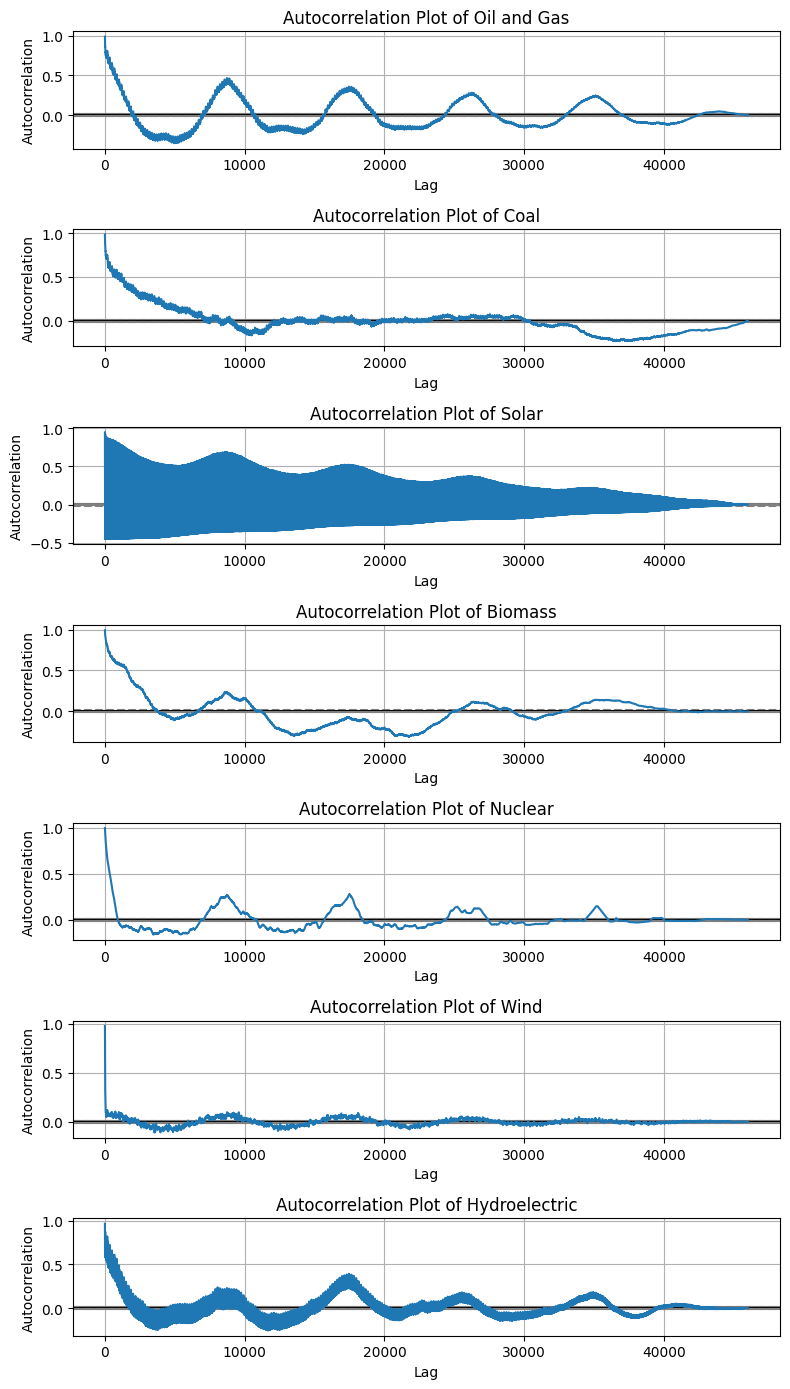

In [16]:
fig, axes = plt.subplots(len(energy_sources), 1, figsize=(8, 2 * len(energy_sources)))

# Loop through each energy source to display its autocorrelation plot
for i, source in enumerate(energy_sources):
    ax = axes[i]
    autocorrelation_plot(df[source], ax=ax)
    ax.set_title(f'Autocorrelation Plot of {source}')
    ax.grid(True)

plt.tight_layout()
plt.show()

Biomass
* Shows some periodic fluctuations but less pronounced than oil/gas
* Maintains small oscillations around zero after initial decay
* Pattern suggests **medium-term memory** in the system

Nuclear
* Shows clearer periodic patterns than biomass
* Smaller amplitude in oscillations compared to oil/gas

Wind
* Very small correlation values after initial drop
* Shows minimal periodic behavior
* Most "noisy" pattern among all sources
* Suggests wind power is least predictable/most random

Oil and Gas
* Strong, consistent periodic pattern
* Clear cyclic behavior throughout all lags
* Higher amplitude oscillations than other sources
* Maintains pattern integrity even at higher lags
* Suggests strong seasonal or market-driven cycles
* Most structured autocorrelation among all sources

Coal
* Limited periodic behavior
* More sustained initial correlation than nuclear or wind
* Pattern suggests longer-term dependencies
* More predictable than wind but less than oil/gas

Solar
* Unique filled pattern showing variance bounds
* Strongest long-term correlation persistence
* Gradual decay with clear seasonal components
* Maintains positive correlation for longest period
* Shows clear seasonal patterns
* Most predictable long-term behavior

## Mix of electricity production

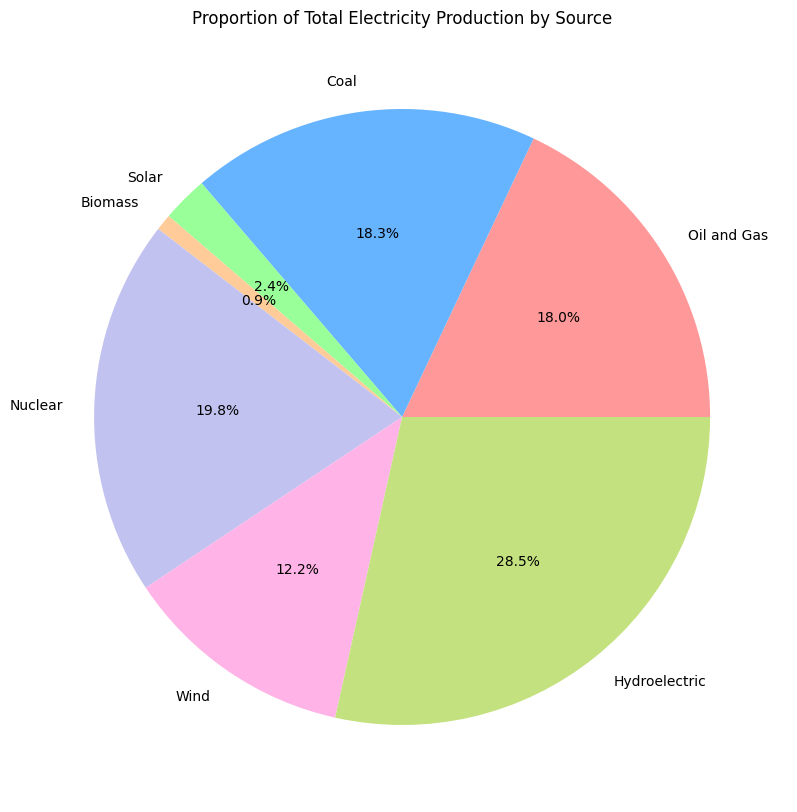

In [17]:
total_production_by_source = df[energy_sources].sum()

plt.figure(figsize=(10, 10))
total_production_by_source.plot(kind='pie', autopct='%1.1f%%', colors=['#ff9999','#66b3ff','#99ff99','#ffcc99','#c2c2f0','#ffb3e6','#c4e17f'])
plt.ylabel('')
plt.title('Proportion of Total Electricity Production by Source')
plt.show()

# 2nd Part Forecasting Electricity Production

## Data pre-processing

In [18]:
# Add time-based features
df['hour'] = pd.to_datetime(df['DateTime']).dt.hour
df['dayofweek'] = pd.to_datetime(df['DateTime']).dt.dayofweek

# Normalize the data
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(df[['Production', 'Nuclear', 'Wind', 'Hydroelectric', 'Oil and Gas', 'Coal', 'Solar', 'Biomass', 'hour', 'dayofweek']])

# Convert to a DataFrame
scaled_df = pd.DataFrame(scaled_df, columns=['Production', 'Nuclear', 'Wind', 'Hydroelectric', 'Oil and Gas', 'Coal', 'Solar', 'Biomass', 'hour', 'dayofweek'])

## Time Series Sequence Preparation + Sliding Window Creation

In [19]:
# Create sequences
def create_sequences(df, seq_length):
    sequences = []
    labels = []
    for i in range(len(df) - seq_length):
        seq = df.iloc[i:i+seq_length].values
        label = df['Production'].iloc[i+seq_length]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

SEQ_LENGTH = 24  # for 24 hours sequence
sequences, labels = create_sequences(scaled_df, SEQ_LENGTH)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(sequences, labels, test_size=0.2, shuffle=False)

## LSTM (Long Short-Term Memory) Model

In [35]:
wandb.finish() # In case the previous was interupted in the middle

EPOCH_NB = 20
learning_rate = 0.01
dropout = 0.35
batch_size = 128

wandb.init(
    project="time-series-prediction-electricity-production",
    name=f"LSTM_epochs_{EPOCH_NB}_lr_{learning_rate}_dropout_{dropout}_batch-size_{batch_size}",
    group="LSTM",
)

config = wandb.config
config.epochs = EPOCH_NB
config.batch_size = batch_size
config.learning_rate = learning_rate
config.dropout_1 = dropout
config.dropout_2 = dropout
config.dropout_3 = dropout   
config.lstm_units_1 = 100
config.lstm_units_2 = 50
config.lstm_units_3 = 50

# Récupérer la configuration depuis wandb
config = wandb.config

# LSTM Model Definition
model_LSTM = Sequential([
    Bidirectional(LSTM(config.lstm_units_1, return_sequences=True, input_shape=(SEQ_LENGTH, X_train.shape[2]))),
    Dropout(config.dropout_1),
    LSTM(config.lstm_units_2, return_sequences=True),
    Dropout(config.dropout_2),
    LSTM(config.lstm_units_2),
    Dropout(config.dropout_3),
    Dense(1)
])

# Initialiser l'optimiseur
optimizer = Adam(learning_rate=config.learning_rate)
model_LSTM.compile(optimizer=optimizer, loss='mean_squared_error')

# Callbacks pour early stopping et réduction du learning rate
early_stopping_LSTM = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr_LSTM = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

# Entraînement du modèle avec le suivi du temps
start_time = time.time()

history_LSTM = model_LSTM.fit(
    X_train, y_train,
    epochs=config.epochs,
    batch_size=config.batch_size,
    validation_split=0.2,
        callbacks=[early_stopping_LSTM, reduce_lr_LSTM, WandbMetricsLogger()]

)

end_time = time.time()
execution_time = end_time - start_time

# Prédictions
predictions_LSTM = model_LSTM.predict(X_test)

# Calculer les métriques d'évaluation
r2_LSTM = r2_score(y_test, predictions_LSTM)
mae_LSTM = mean_absolute_error(y_test, predictions_LSTM)
mse_LSTM = mean_squared_error(y_test, predictions_LSTM)
rmse_LSTM = np.sqrt(mse_LSTM)

# Enregistrer les métriques et le temps d'exécution dans wandb
wandb.log({
    'R² Score': r2_LSTM,
    'MAE': mae_LSTM,
    'MSE': mse_LSTM,
    'RMSE': rmse_LSTM,
    'Training Time (s)': execution_time
})

# Afficher les résultats
print(f'R² Score: {r2_LSTM}')
print(f'Mean Absolute Error (MAE): {mae_LSTM}')
print(f'Mean Squared Error (MSE): {mse_LSTM}')
print(f'Root Mean Squared Error (RMSE): {rmse_LSTM}')
print(f'Training Time: {execution_time} seconds')

wandb.finish()

model_LSTM.summary()

Epoch 1/20


c:\Users\ledou\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


230/230 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - loss: 0.0893 - val_loss: 0.0016 - learning_rate: 0.0100
Epoch 2/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - loss: 0.0042 - val_loss: 0.0012 - learning_rate: 0.0100
Epoch 3/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - loss: 0.0028 - val_loss: 9.5393e-04 - learning_rate: 0.0100
Epoch 4/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - loss: 0.0020 - val_loss: 8.0431e-04 - learning_rate: 0.0100
Epoch 5/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - loss: 0.0016 - val_loss: 7.3974e-04 - learning_rate: 0.0100
Epoch 6/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.0014 - val_loss: 0.0012 - learning_rate: 0.0100
Epoch 7/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 0.0013 - val_loss: 6.5225e-04 - learning_rate: 0.0100
Epoch 8/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 0.0012 - val_loss: 6.7242e-04 - learning_rate: 0.0100
Epoch 9/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 0.0012 - val_loss: 6.6727e-04 - learning_

MAE,▁
MSE,▁
RMSE,▁
R² Score,▁
Training Time (s),▁
epoch/epoch,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
epoch/learning_rate,███████████▃▃▃▃▃▁
epoch/loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_loss,█▅▃▂▂▅▁▁▁▂▂▁▁▁▁▂▁
MAE,0.02132
MSE,0.00082


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_2 (Bidirectional) │ (None, 24, 200)        │        88,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 24, 200)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 24, 50)         │        50,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 24, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 477,755 (1.82 MB)

 Trainable params: 159,251 (622.07 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 318,504 (1.22 MB)

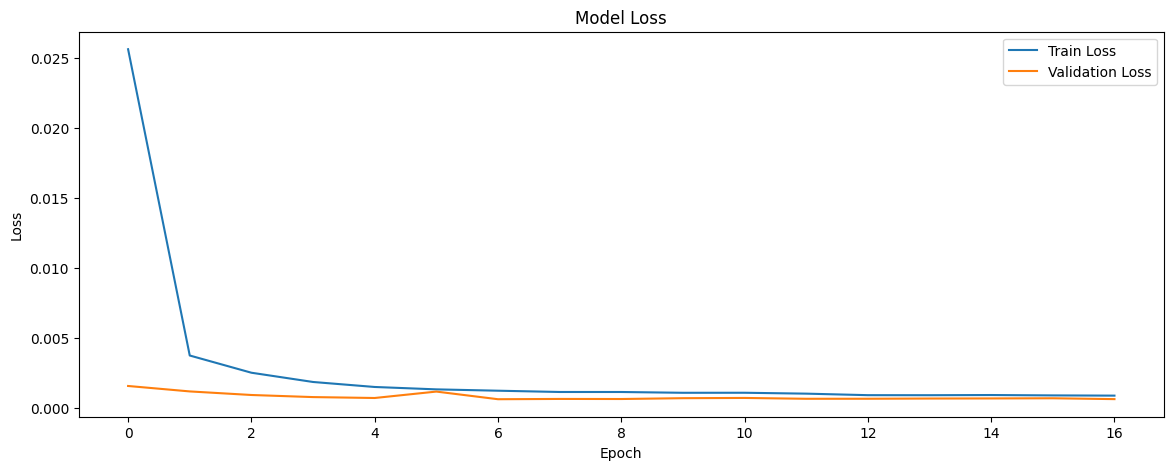

In [36]:
# Plot training & validation loss values
plt.figure(figsize=(14, 5))
plt.plot(history_LSTM.history['loss'], label='Train Loss')
plt.plot(history_LSTM.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


## Result LSTM Model

In [37]:
def calculate_residuals(actual, predicted, chunk_size=1000):
    """
    Calculate residuals efficiently for large datasets by processing in chunks.
    """
    # Ensure inputs are 1D arrays
    if hasattr(actual, 'shape') and len(actual.shape) > 1:
        actual = actual.ravel()
    if hasattr(predicted, 'shape') and len(predicted.shape) > 1:
        predicted = predicted.ravel()
    
    # Convert to numpy arrays first
    actual = np.asarray(actual)
    predicted = np.asarray(predicted)
    
    # Create index
    index = pd.RangeIndex(len(actual))
    
    # Convert to pandas Series
    actual = pd.Series(actual, index=index)
    predicted = pd.Series(predicted, index=index)
    
    # Preallocate residuals Series
    residuals = pd.Series(index=index, dtype=float)
    
    # Process in chunks
    for i in range(0, len(actual), chunk_size):
        chunk_slice = slice(i, i + chunk_size)
        residuals.iloc[chunk_slice] = actual.iloc[chunk_slice] - predicted.iloc[chunk_slice]
    
    # Calculate statistics
    stats = {
        'mean': residuals.mean(),
        'std': residuals.std(),
        'mae': np.abs(residuals).mean(),
        'mse': (residuals ** 2).mean(),
        'rmse': np.sqrt((residuals ** 2).mean())
    }
    
    return residuals, stats

In [38]:
residuals_LSTM, stats_LSTM = calculate_residuals(y_test, predictions_LSTM)

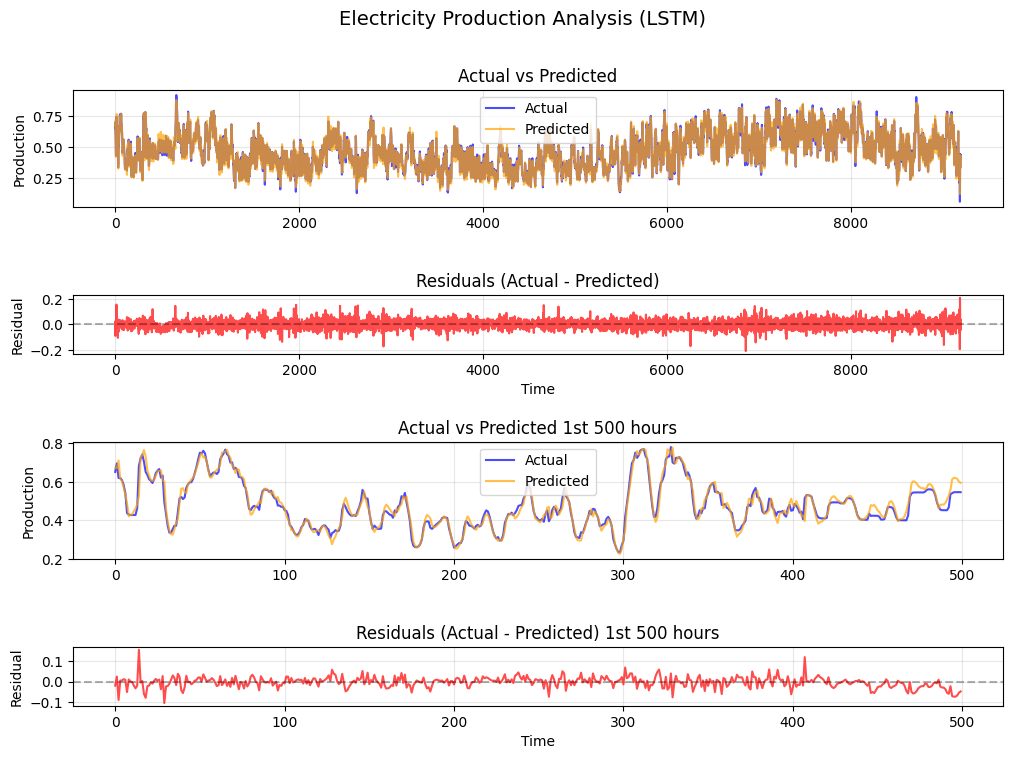

In [39]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 8), height_ratios=[2, 1, 2, 1])
fig.suptitle('Electricity Production Analysis (LSTM)', fontsize=14)

# Plot 1: Original comparison
ax1.plot(y_test, label='Actual', color='blue', alpha=0.7)
ax1.plot(predictions_LSTM, label='Predicted', color='orange', alpha=0.7)
ax1.set_ylabel('Production')
ax1.set_title('Actual vs Predicted')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Residuals 
ax2.plot(residuals_LSTM, label='Residual', color='red', alpha=0.7)
ax2.axhline(y=0, color='black', linestyle='--', alpha=0.3)
ax2.set_xlabel('Time')
ax2.set_ylabel('Residual')
ax2.set_title('Residuals (Actual - Predicted)')
ax2.grid(True, alpha=0.3)

# Plot 3: Original comparison 1st 500 hours
ax3.plot(y_test[:500], label='Actual', color='blue', alpha=0.7)
ax3.plot(predictions_LSTM[:500], label='Predicted', color='orange', alpha=0.7)
ax3.set_ylabel('Production')
ax3.set_title('Actual vs Predicted 1st 500 hours')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Residuals 1st 500 hours
ax4.plot(residuals_LSTM[:500], label='Residual', color='red', alpha=0.7)
ax4.axhline(y=0, color='black', linestyle='--', alpha=0.3)
ax4.set_xlabel('Time')
ax4.set_ylabel('Residual')
ax4.set_title('Residuals (Actual - Predicted) 1st 500 hours')
ax4.grid(True, alpha=0.3)

plt.subplots_adjust(hspace=1)

## TCN (Temporal Convolutional Networks) Model

In [40]:
wandb.finish() # In case the previous was interupted in the middle

EPOCH_NB = 20
learning_rate = 0.01
dropout = 0.35
batch_size = 128

wandb.init(
    project="time-series-prediction-electricity-production",
    name=f"TCN_epochs_{EPOCH_NB}_lr_{learning_rate}_dropout_{dropout}_batch-size_{batch_size}",
    group="TCN",
)

config = wandb.config
config.epochs = EPOCH_NB
config.batch_size = batch_size
config.learning_rate = learning_rate
config.dropout = dropout 
config.kernel_size = 3
config.kernel_size2 = 9
config.filter = 64

# Récupérer la configuration depuis wandb
config = wandb.config

# Model Definition
def TCN_Block(inputs, filters, kernel_size, dilation_rate, dropout_rate=0.2):
    # Causal Convolution Block for TCN
    x = layers.Conv1D(filters=filters, kernel_size=kernel_size, dilation_rate=dilation_rate, padding='causal')(inputs)
    x = layers.ReLU()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.BatchNormalization()(x)
    return x

# Build the TCN model
def build_TCN(input_shape):
    inputs = layers.Input(shape=input_shape)
    
    # TCN blocks with increasing dilation rates and kernel sizes to see higher seasonality
    x = TCN_Block(inputs, filters=config.filter, kernel_size=config.kernel_size, dilation_rate=1, dropout_rate=config.dropout)
    x = TCN_Block(x, filters=config.filter, kernel_size=config.kernel_size, dilation_rate=2, dropout_rate=config.dropout)
    x = TCN_Block(x, filters=config.filter, kernel_size=config.kernel_size, dilation_rate=3, dropout_rate=config.dropout)
    x = TCN_Block(x, filters=config.filter, kernel_size=config.kernel_size, dilation_rate=4, dropout_rate=config.dropout)
    x = TCN_Block(x, filters=config.filter, kernel_size=config.kernel_size, dilation_rate=5, dropout_rate=config.dropout)
    x = TCN_Block(x, filters=config.filter, kernel_size=config.kernel_size, dilation_rate=6, dropout_rate=config.dropout)
    x = TCN_Block(x, filters=config.filter, kernel_size=config.kernel_size2, dilation_rate=24, dropout_rate=config.dropout) # One day
    #x = TCN_Block(x, filters=64, kernel_size=9, dilation_rate=128) # One week
    
    # Global pooling and dense layers
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dense(1)(x)  
    
    model = models.Model(inputs, x)
    return model

# Define the model
model_TCN = build_TCN((SEQ_LENGTH, X_train.shape[2]))

# Compile the model
model_TCN.compile(optimizer='adam', loss='mean_squared_error')

# Print the model summary
model_TCN.summary()

# Callbacks for early stopping and learning rate reduction
early_stopping_TCN = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr_TCN = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

start_time = time.time()

# Train the model
history_TCN = model_TCN.fit(X_train, y_train, epochs=config.epochs, batch_size=config.batch_size, validation_split=0.2, 
                    callbacks=[early_stopping_TCN, reduce_lr_TCN, WandbMetricsLogger()])

end_time = time.time()
execution_time = end_time - start_time

# Model Evaluation
predictions_TCN = model_TCN.predict(X_test)

# Calculate evaluation metrics
r2_TCN = r2_score(y_test, predictions_TCN)
mae_TCN = mean_absolute_error(y_test, predictions_TCN)
mse_TCN = mean_squared_error(y_test, predictions_TCN)
rmse_TCN = np.sqrt(mse_TCN)

wandb.log({
    'R² Score': r2_TCN,
    'MAE': mae_TCN,
    'MSE': mse_TCN,
    'RMSE': rmse_TCN,
    'Training Time (s)': execution_time
})

print(f'R² Score: {r2_TCN}')
print(f'Mean Absolute Error (MAE): {mae_TCN}')
print(f'Mean Squared Error (MSE): {mse_TCN}')
print(f'Root Mean Squared Error (RMSE): {rmse_TCN}')

wandb.finish()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 24, 10)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 24, 64)         │         1,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_7 (ReLU)                  │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 24, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 24, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_8 (ReLU)                  │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 24, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 24, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_9 (ReLU)                  │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 24, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_12 (Conv1D)              │ (None, 24, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_10 (ReLU)                 │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 24, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 24, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_11 (ReLU)                 │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 24, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_14 (Conv1D)              │ (None, 24, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 106,689 (416.75 KB)

 Trainable params: 105,793 (413.25 KB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 14s 43ms/step - loss: 0.0641 - val_loss: 0.0147 - learning_rate: 0.0010
Epoch 2/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - loss: 0.0134 - val_loss: 0.0097 - learning_rate: 0.0010
Epoch 3/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - loss: 0.0098 - val_loss: 0.0074 - learning_rate: 0.0010
Epoch 4/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - loss: 0.0081 - val_loss: 0.0062 - learning_rate: 0.0010
Epoch 5/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - loss: 0.0065 - val_loss: 0.0052 - learning_rate: 0.0010
Epoch 6/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - loss: 0.0055 - val_loss: 0.0050 - learning_rate: 0.0010
Epoch 7/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - loss: 0.0049 - val_loss: 0.0034 - learning_rate: 0.0010
Epoch 8/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - loss: 0.0046 - val_loss: 0.0032 - learning_rate: 0.0010
Epoch 9/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - loss: 0.0041 - val_loss: 0.0027 - learning_rate: 0.00

MAE,▁
MSE,▁
RMSE,▁
R² Score,▁
Training Time (s),▁
epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_loss,█▅▄▃▃▃▂▂▂▂▁▂▁▂▁▁▂▁▁▁
MAE,0.03174
MSE,0.00167


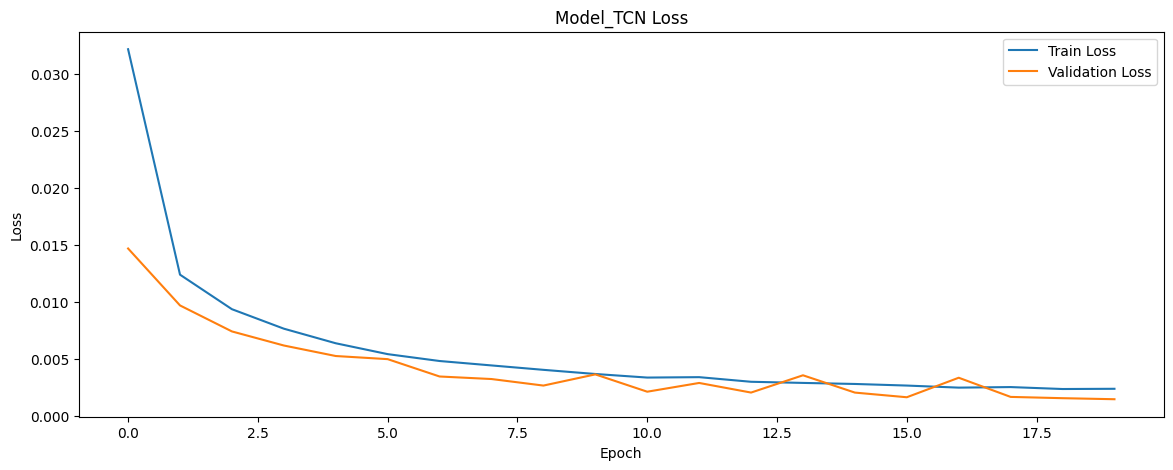

In [41]:
# Plot training & validation loss values
plt.figure(figsize=(14, 5))
plt.plot(history_TCN.history['loss'], label='Train Loss')
plt.plot(history_TCN.history['val_loss'], label='Validation Loss')
plt.title('Model_TCN Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Result TCN Model

In [42]:
residuals_TCN, stats_TCN = calculate_residuals(y_test, predictions_TCN,500)

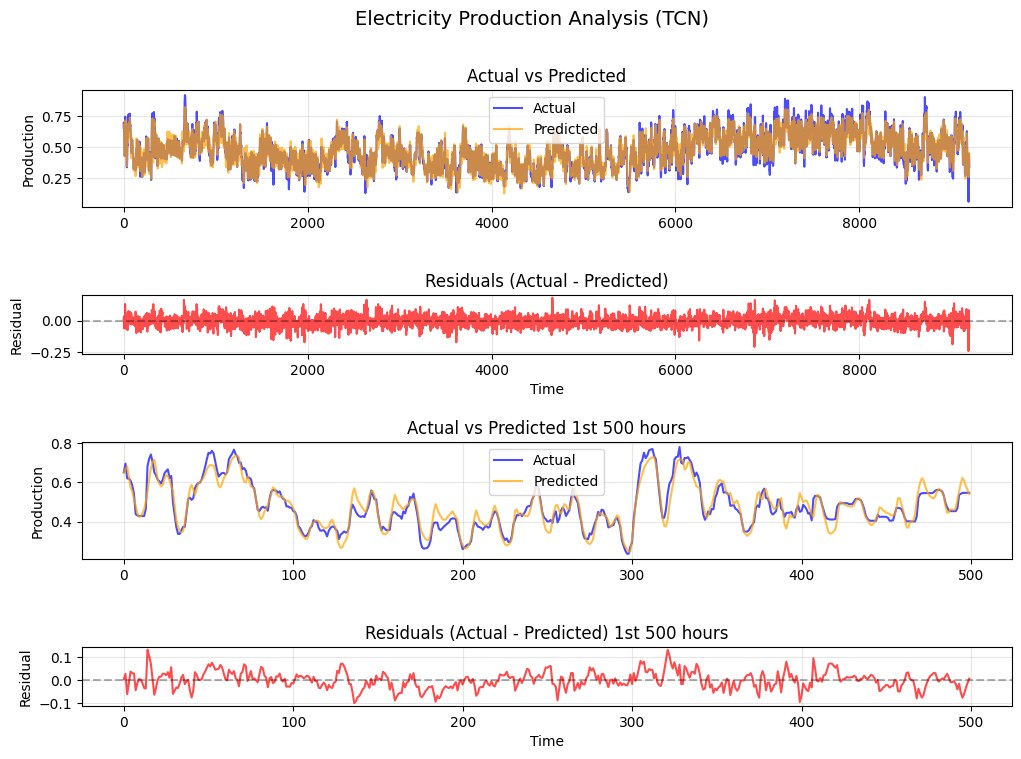

In [43]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 8), height_ratios=[2, 1, 2, 1])
fig.suptitle('Electricity Production Analysis (TCN)', fontsize=14)

# Plot 1: Original comparison
ax1.plot(y_test, label='Actual', color='blue', alpha=0.7)
ax1.plot(predictions_TCN, label='Predicted', color='orange', alpha=0.7)
ax1.set_ylabel('Production')
ax1.set_title('Actual vs Predicted')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Residuals 
ax2.plot(residuals_TCN, label='Residual', color='red', alpha=0.7)
ax2.axhline(y=0, color='black', linestyle='--', alpha=0.3)
ax2.set_xlabel('Time')
ax2.set_ylabel('Residual')
ax2.set_title('Residuals (Actual - Predicted)')
ax2.grid(True, alpha=0.3)

# Plot 3: Original comparison 1st 500 hours
ax3.plot(y_test[:500], label='Actual', color='blue', alpha=0.7)
ax3.plot(predictions_TCN[:500], label='Predicted', color='orange', alpha=0.7)
ax3.set_ylabel('Production')
ax3.set_title('Actual vs Predicted 1st 500 hours')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Residuals 1st 500 hours
ax4.plot(residuals_TCN[:500], label='Residual', color='red', alpha=0.7)
ax4.axhline(y=0, color='black', linestyle='--', alpha=0.3)
ax4.set_xlabel('Time')
ax4.set_ylabel('Residual')
ax4.set_title('Residuals (Actual - Predicted) 1st 500 hours')
ax4.grid(True, alpha=0.3)

plt.subplots_adjust(hspace=1)

## GRU models

In [29]:
wandb.finish() # In case the previous was interupted in the middle

EPOCH_NB = 20
learning_rate = 0.005
dropout = 0.35
batch_size = 64

wandb.init(
    project="time-series-prediction-electricity-production",
    name=f"GRU_epochs_{EPOCH_NB}_lr_{learning_rate}_dropout_{dropout}_batch-size_{batch_size}",
    group="GRU",
)

config = wandb.config
config.epochs = EPOCH_NB
config.batch_size = batch_size
config.learning_rate = learning_rate
config.dropout_1 = dropout
config.dropout_2 = dropout
config.dropout_3 = dropout   
config.gru_units_1 = 100
config.gru_units_2 = 50

# Récupérer la configuration depuis wandb
config = wandb.config

# GRU Model Definition
model_GRU = Sequential([
    Bidirectional(GRU(config.gru_units_1, return_sequences=True, input_shape=(SEQ_LENGTH, X_train.shape[2]))),
    Dropout(config.dropout_1),
    GRU(config.gru_units_2, return_sequences=True),
    Dropout(config.dropout_2),
    GRU(config.gru_units_2),
    Dropout(config.dropout_3),
    Dense(1)
])


# Initialiser l'optimiseur
optimizer = Adam(learning_rate=config.learning_rate)
model_GRU.compile(optimizer=optimizer, loss='mean_squared_error')

# Callbacks pour early stopping et réduction du learning rate
early_stopping_GRU = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr_GRU = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

# Entraînement du modèle avec le suivi du temps
start_time = time.time()

history_GRU = model_GRU.fit(
    X_train, y_train,
    epochs=config.epochs,
    batch_size=config.batch_size,
    validation_split=0.2,
        callbacks=[early_stopping_GRU, reduce_lr_GRU, WandbMetricsLogger()]

)

end_time = time.time()
execution_time = end_time - start_time

# Prédictions
predictions_GRU = model_GRU.predict(X_test)

# Calculer les métriques d'évaluation
r2_GRU = r2_score(y_test, predictions_GRU)
mae_GRU = mean_absolute_error(y_test, predictions_GRU)
mse_GRU = mean_squared_error(y_test, predictions_GRU)
rmse_GRU = np.sqrt(mse_GRU)

# Enregistrer les métriques et le temps d'exécution dans wandb
wandb.log({
    'R² Score': r2_GRU,
    'MAE': mae_GRU,
    'MSE': mse_GRU,
    'RMSE': rmse_GRU,
    'Training Time (s)': execution_time
})

# Afficher les résultats
print(f'R² Score: {r2_GRU}')
print(f'Mean Absolute Error (MAE): {mae_GRU}')
print(f'Mean Squared Error (MSE): {mse_GRU}')
print(f'Root Mean Squared Error (RMSE): {rmse_GRU}')
print(f'Training Time: {execution_time} seconds')

wandb.finish()

model_GRU.summary()

Epoch 1/20


c:\Users\ledou\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


460/460 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - loss: 0.0288 - val_loss: 0.0013 - learning_rate: 0.0050
Epoch 2/20
460/460 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.0033 - val_loss: 8.9012e-04 - learning_rate: 0.0050
Epoch 3/20
460/460 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - loss: 0.0020 - val_loss: 9.5077e-04 - learning_rate: 0.0050
Epoch 4/20
460/460 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - loss: 0.0015 - val_loss: 7.2968e-04 - learning_rate: 0.0050
Epoch 5/20
460/460 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - loss: 0.0013 - val_loss: 6.8374e-04 - learning_rate: 0.0050
Epoch 6/20
460/460 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - loss: 0.0013 - val_loss: 6.9044e-04 - learning_rate: 0.0050
Epoch 7/20
460/460 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.0012 - val_loss: 6.3244e-04 - learning_rate: 0.0050
Epoch 8/20
460/460 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - loss: 0.0011 - val_loss: 7.6462e-04 - learning_rate: 0.0050
Epoch 9/20
460/460 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - loss: 0.0011 - val_loss: 8.1417

MAE,▁
MSE,▁
RMSE,▁
R² Score,▁
Training Time (s),▁
epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/learning_rate,████████▄▄▄▄▄▄▂▂▂▂▂▁
epoch/loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_loss,█▄▅▃▂▂▂▃▄▂▂▂▂▃▁▁▁▂▁▃
MAE,0.02012
MSE,0.00075


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional) │ (None, 24, 200)        │        67,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 24, 200)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 24, 50)         │        37,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 24, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 50)             │        15,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 361,055 (1.38 MB)

 Trainable params: 120,351 (470.12 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 240,704 (940.25 KB)

In [44]:
residuals_GRU, stats_GRU = calculate_residuals(y_test, predictions_GRU,500)

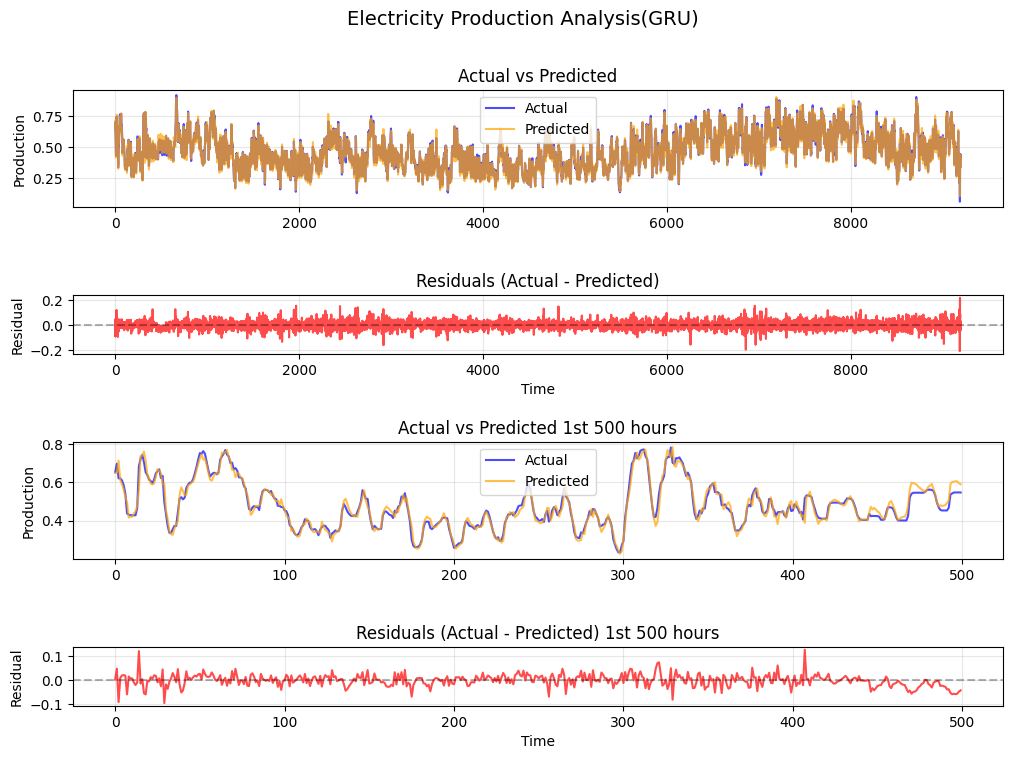

In [45]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 8), height_ratios=[2, 1, 2, 1])
fig.suptitle('Electricity Production Analysis(GRU)', fontsize=14)

# Plot 1: Original comparison
ax1.plot(y_test, label='Actual', color='blue', alpha=0.7)
ax1.plot(predictions_GRU, label='Predicted', color='orange', alpha=0.7)
ax1.set_ylabel('Production')
ax1.set_title('Actual vs Predicted')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Residuals 
ax2.plot(residuals_GRU, label='Residual', color='red', alpha=0.7)
ax2.axhline(y=0, color='black', linestyle='--', alpha=0.3)
ax2.set_xlabel('Time')
ax2.set_ylabel('Residual')
ax2.set_title('Residuals (Actual - Predicted)')
ax2.grid(True, alpha=0.3)

# Plot 3: Original comparison 1st 500 hours
ax3.plot(y_test[:500], label='Actual', color='blue', alpha=0.7)
ax3.plot(predictions_GRU[:500], label='Predicted', color='orange', alpha=0.7)
ax3.set_ylabel('Production')
ax3.set_title('Actual vs Predicted 1st 500 hours')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Residuals 1st 500 hours
ax4.plot(residuals_GRU[:500], label='Residual', color='red', alpha=0.7)
ax4.axhline(y=0, color='black', linestyle='--', alpha=0.3)
ax4.set_xlabel('Time')
ax4.set_ylabel('Residual')
ax4.set_title('Residuals (Actual - Predicted) 1st 500 hours')
ax4.grid(True, alpha=0.3)

plt.subplots_adjust(hspace=1)

## CNN models

In [55]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten

wandb.finish() # In case the previous was interupted in the middle

EPOCH_NB = 50
learning_rate = 0.01
dropout = 0.35
batch_size = 64

wandb.init(
    project="time-series-prediction-electricity-production",
    name=f"CNN_epochs_{EPOCH_NB}_lr_{learning_rate}_dropout_{dropout}_batch-size_{batch_size}",
    group="CNN",   
)

config = wandb.config
config.epochs = EPOCH_NB
config.batch_size = batch_size
config.learning_rate = learning_rate
config.dropout_1 = dropout
config.dropout_2 = dropout
config.dropout_3 = dropout   
config.cnn_units_1 = 100
config.cnn_units_2 = 50
config.cnn_units_3 = 50

# Récupérer la configuration depuis wandb
config = wandb.config

# CNN Model Definition
model_CNN = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(SEQ_LENGTH, X_train.shape[2])),
    MaxPooling1D(pool_size=2),
    Dropout(config.dropout_1),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(config.dropout_2),
    Flatten(),
    Dense(50, activation='relu'),
    Dropout(config.dropout_3),
    Dense(1)
])



# Initialiser l'optimiseur
optimizer = Adam(learning_rate=config.learning_rate)
model_CNN.compile(optimizer=optimizer, loss='mean_squared_error')

# Callbacks pour early stopping et réduction du learning rate
early_stopping_CNN = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr_CNN = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

# Entraînement du modèle avec le suivi du temps
start_time = time.time()

history_CNN = model_CNN.fit(
    X_train, y_train,
    epochs=config.epochs,
    batch_size=config.batch_size,
    validation_split=0.2,
        callbacks=[early_stopping_CNN, reduce_lr_CNN, WandbMetricsLogger()]

)

end_time = time.time()
execution_time = end_time - start_time

# Prédictions
predictions_CNN = model_CNN.predict(X_test)

# Calculer les métriques d'évaluation
r2_CNN = r2_score(y_test, predictions_CNN)
mae_CNN = mean_absolute_error(y_test, predictions_CNN)
mse_CNN = mean_squared_error(y_test, predictions_CNN)
rmse_CNN = np.sqrt(mse_CNN)

# Enregistrer les métriques et le temps d'exécution dans wandb
wandb.log({
    'R² Score': r2_CNN,
    'MAE': mae_CNN,
    'MSE': mse_CNN,
    'RMSE': rmse_CNN,
    'Training Time (s)': execution_time
})

# Afficher les résultats
print(f'R² Score: {r2_CNN}')
print(f'Mean Absolute Error (MAE): {mae_CNN}')
print(f'Mean Squared Error (MSE): {mse_CNN}')
print(f'Root Mean Squared Error (RMSE): {rmse_CNN}')
print(f'Training Time: {execution_time} seconds')

wandb.finish()

model_CNN.summary()

Epoch 1/50


c:\Users\ledou\miniconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


460/460 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.1400 - val_loss: 0.0115 - learning_rate: 0.0100
Epoch 2/50
460/460 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0092 - val_loss: 0.0146 - learning_rate: 0.0100
Epoch 3/50
460/460 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0089 - val_loss: 0.0092 - learning_rate: 0.0100
Epoch 4/50
460/460 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0085 - val_loss: 0.0099 - learning_rate: 0.0100
Epoch 5/50
460/460 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0085 - val_loss: 0.0082 - learning_rate: 0.0100
Epoch 6/50
460/460 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0080 - val_loss: 0.0076 - learning_rate: 0.0100
Epoch 7/50
460/460 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0080 - val_loss: 0.0070 - learning_rate: 0.0100
Epoch 8/50
460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0076 - val_loss: 0.0095 - learning_rate: 0.0100
Epoch 9/50
460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0077 - val_loss: 0.0109 - learning_rate: 0.0100
Epoch 10/50
460/460 ━

MAE,▁
MSE,▁
RMSE,▁
R² Score,▁
Training Time (s),▁
epoch/epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
epoch/learning_rate,███████████▄▄▄▄▄▄▂▂▂▂▂▂▂▁▁▁▁▁▁
epoch/loss,█▂▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_loss,▅█▄▄▃▂▂▄▅▃▃▂▁▂▂▂▃▄▂▁▂▂▂▂▂▂▂▂▂▂
MAE,0.06065
MSE,0.00592


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_24 (Conv1D)              │ (None, 22, 64)         │         1,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_10 (MaxPooling1D) │ (None, 11, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 11, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_25 (Conv1D)              │ (None, 9, 128)         │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_11 (MaxPooling1D) │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 50)             │        25,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 157,169 (613.95 KB)

 Trainable params: 52,389 (204.64 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 104,780 (409.30 KB)

In [56]:
residuals_CNN, stats_CNN = calculate_residuals(y_test, predictions_CNN,500)

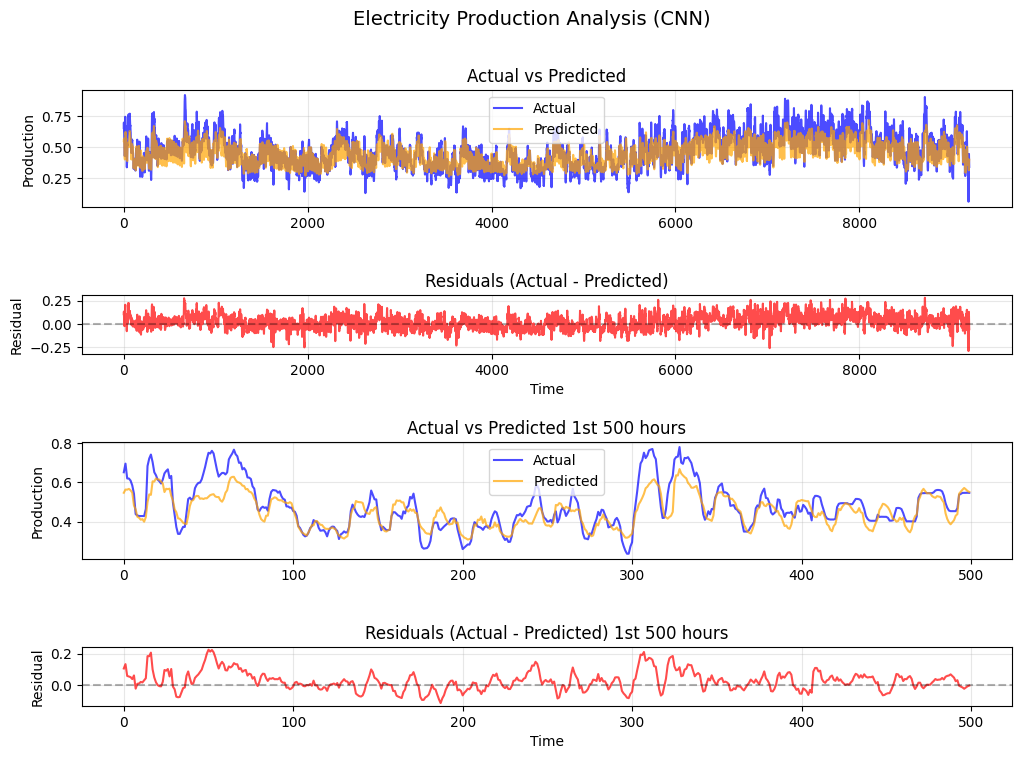

In [57]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 8), height_ratios=[2, 1, 2, 1])
fig.suptitle('Electricity Production Analysis (CNN)', fontsize=14)

# Plot 1: Original comparison
ax1.plot(y_test, label='Actual', color='blue', alpha=0.7)
ax1.plot(predictions_CNN, label='Predicted', color='orange', alpha=0.7)
ax1.set_ylabel('Production')
ax1.set_title('Actual vs Predicted')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Residuals 
ax2.plot(residuals_CNN, label='Residual', color='red', alpha=0.7)
ax2.axhline(y=0, color='black', linestyle='--', alpha=0.3)
ax2.set_xlabel('Time')
ax2.set_ylabel('Residual')
ax2.set_title('Residuals (Actual - Predicted)')
ax2.grid(True, alpha=0.3)

# Plot 3: Original comparison 1st 500 hours
ax3.plot(y_test[:500], label='Actual', color='blue', alpha=0.7)
ax3.plot(predictions_CNN[:500], label='Predicted', color='orange', alpha=0.7)
ax3.set_ylabel('Production')
ax3.set_title('Actual vs Predicted 1st 500 hours')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Residuals 1st 500 hours
ax4.plot(residuals_CNN[:500], label='Residual', color='red', alpha=0.7)
ax4.axhline(y=0, color='black', linestyle='--', alpha=0.3)
ax4.set_xlabel('Time')
ax4.set_ylabel('Residual')
ax4.set_title('Residuals (Actual - Predicted) 1st 500 hours')
ax4.grid(True, alpha=0.3)

plt.subplots_adjust(hspace=1)

Modèle	Dépendances à long terme	Parallélisme	Complexité	Utilisation typique

LSTM	Oui	Faible	Moyenne	Séries temporelles, NLP

GRU	Oui	Faible	Faible	Séries temporelles simples

TCN	Oui	Élevé	Moyenne	Séries temporelles, séquences

Transformer	Oui	Très élevé	Élevée	Séries complexes, multivariées

Echo State Network	Limité	Élevé	Faible	Modèles légers, rapides

Seq2Seq avec Attention	Oui	Moyenne	Moyenne	Traduction, séquences variables

WaveNet	Oui	Élevé	Moyenne	Génération, signaux audio

N-BEATS	Oui	Élevé	Moyenne	Prévisions (finance, énergie)
